# Dog Breeds Kaggle Competition -- fast.ai

## Setup

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
PATH = "data/dogbreed/"
image_size=224
arch=resnext101_64
batch_size=64

In [5]:
label_csv = f'{PATH}labels.csv'
num_labels = len(list(open(label_csv)))-1

In [6]:
# create a set of validation indices (i.e. indices not used for training -- by default it gets 20% of total for validation)
val_idxs = get_cv_idxs(num_labels)

## Data Exploration

In [7]:
!ls {PATH}

labels.csv	sample_submission.csv.zip  test.zip  train
labels.csv.zip	test			   tmp	     train.zip


In [8]:
label_df = pd.read_csv(label_csv)

In [9]:
label_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [10]:
label_df.pivot_table(index='breed', aggfunc=len).sort_values('id', ascending=False)

,id
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114
shih-tzu,112
great_pyrenees,111
pomeranian,111
basenji,110


In [8]:
# Use data augmentatioin on training images
tfms = tfms_from_model(arch, image_size, aug_tfms=transforms_side_on, max_zoom=1.1)

In [9]:
data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name='test',
                                    val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=batch_size)

In [10]:
fn = PATH+data.trn_ds.fnames[0]; fn

'data/dogbreed/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg'

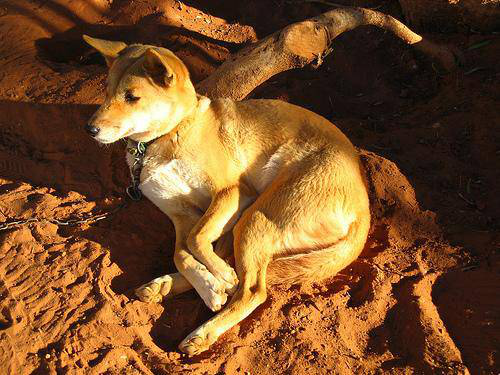

In [11]:
img = PIL.Image.open(fn); img

In [15]:
img.size

(500, 375)

In [16]:
size_d = {k: PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames}

In [17]:
row_size,col_size = list(zip(*size_d.values()))
row_size = np.array(row_size); col_size = np.array(col_size)

In [18]:
row_size[:5]

array([500, 500, 500, 500, 500])

(array([3023., 5024.,   92.,   15.,    5.,    3.,   13.,    2.,    0.,    1.]),
 array([  97. ,  413.7,  730.4, 1047.1, 1363.8, 1680.5, 1997.2, 2313.9, 2630.6, 2947.3, 3264. ]),
 <a list of 10 Patch objects>)

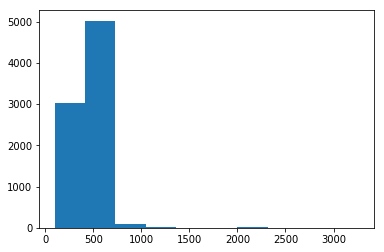

In [19]:
plt.hist(row_size)

(array([ 135.,  592., 1347., 1164., 4599.,  128.,   76.,   62.,   14.,   11.]),
 array([ 97. , 185.5, 274. , 362.5, 451. , 539.5, 628. , 716.5, 805. , 893.5, 982. ]),
 <a list of 10 Patch objects>)

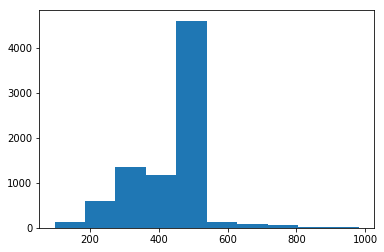

In [20]:
# plot histogram of row_sizes less than 1000
plt.hist(row_size[row_size<1000])

(array([2870., 5121.,  128.,   25.,   10.,   15.,    5.,    2.,    0.,    2.]),
 array([ 102.,  348.,  594.,  840., 1086., 1332., 1578., 1824., 2070., 2316., 2562.]),
 <a list of 10 Patch objects>)

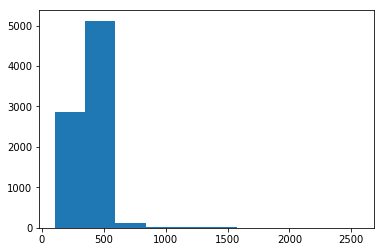

In [21]:
plt.hist(col_size)

(array([ 361., 1258., 1622., 4630.,  158.,   69.,   15.,   13.,    1.,    7.]),
 array([  97. ,  215.3,  333.6,  451.9,  570.2,  688.5,  806.8,  925.1, 1043.4, 1161.7, 1280. ]),
 <a list of 10 Patch objects>)

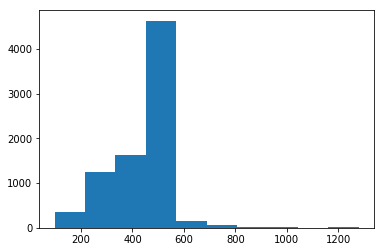

In [22]:
plt.hist(row_size[col_size<1000])

In [23]:
len(data.trn_ds), len(data.test_ds)

(8178, 10357)

In [24]:
len(data.classes), data.classes[:5]

(120,
 ['affenpinscher',
  'afghan_hound',
  'african_hunting_dog',
  'airedale',
  'american_staffordshire_terrier'])

## Initial Model

In [7]:
# changed num_workers to 8 to match num GPUs?
def get_data(arch, image_size, batch_size):
    tfms = tfms_from_model(arch, image_size, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name='test', num_workers=8,
                                    val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=batch_size)
    return data if image_size > 300 else data.resize(340, 'tmp')

### Choose a learning rate

In [8]:
data = get_data(arch, image_size, batch_size)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [14]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [28]:
lrf=learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 87%|████████▋ | 111/128 [00:02<00:00, 46.95it/s, loss=11.4]


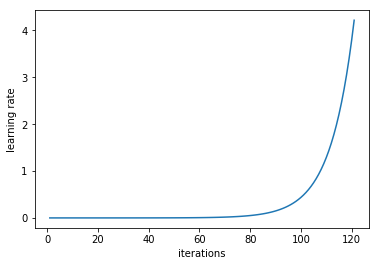

In [29]:
learn.sched.plot_lr()

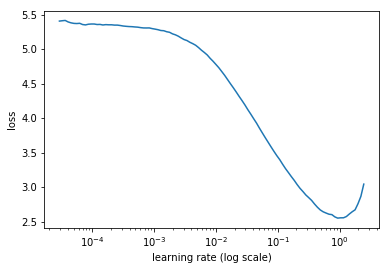

In [30]:
learn.sched.plot()

In [9]:
learn_rate = 1e-1

### Precompute

In [10]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(learn_rate, 3)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.672394   0.465884   0.88418   
    1      0.393948   0.401552   0.899251                    
    2      0.258333   0.330269   0.913477                    



[0.3302691, 0.913476562127471]

### Augment

In [33]:
learn.precompute = False

In [34]:
learn.fit(learn_rate, 2, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.247632   0.245018   0.918327  
    1      0.225641   0.252722   0.917415                    



[0.2527221, 0.9174153637140989]

In [39]:
learn.save('224_pre')

In [40]:
learn.load('224_pre')

### Increase Image Size

In [ ]:
image_size = 299
learn.set_data(get_data(arch, image_size, batch_size))
learn.freeze()

In [ ]:
learn.fit(learn_rate, 2, cycle_len=1)

In [ ]:
learn.fit(learn_rate, 3, cycle_len=1, cycle_mult=2)

### Test Time Augmentation

In [11]:
log_preds,y = learn.TTA()

In [19]:
probs = np.mean(np.exp(log_preds), 0)
metrics.log_loss(y, probs), accuracy_np(probs, y)

(0.3357363206967502, 0.9094911937377691)

In [ ]:
learn.save('299_pre')

In [ ]:
learn.load('299_pre')

In [ ]:
learn.fit(learn_rate, 1, cycle_len=2)

In [ ]:
learn.save('dogbreed_299')

### Analyzing results: looking at pictures

In [25]:
# This is the label for a val data
data.val_y

array([ 19,  15,   7, ..., 109,   3,  28])

In [26]:
# from here we know that 'cats' is label 0 and 'dogs' is label 1.
data.classes

['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle',
 'bedlington_terrier',
 'bernese_mountain_dog',
 'black-and-tan_coonhound',
 'blenheim_spaniel',
 'bloodhound',
 'bluetick',
 'border_collie',
 'border_terrier',
 'borzoi',
 'boston_bull',
 'bouvier_des_flandres',
 'boxer',
 'brabancon_griffon',
 'briard',
 'brittany_spaniel',
 'bull_mastiff',
 'cairn',
 'cardigan',
 'chesapeake_bay_retriever',
 'chihuahua',
 'chow',
 'clumber',
 'cocker_spaniel',
 'collie',
 'curly-coated_retriever',
 'dandie_dinmont',
 'dhole',
 'dingo',
 'doberman',
 'english_foxhound',
 'english_setter',
 'english_springer',
 'entlebucher',
 'eskimo_dog',
 'flat-coated_retriever',
 'french_bulldog',
 'german_shepherd',
 'german_short-haired_pointer',
 'giant_schnauzer',
 'golden_retriever',
 'gordon_setter',
 'great_dane',
 'great_pyrenees',
 'greater_swiss_mountain_dog',
 'groenendael',


In [14]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()

In [ ]:
log_preds.shape

In [29]:
log_preds[:10]

array([[ -7.69997, -10.52919,  -6.22251, ...,  -8.95067, -10.57974,  -7.27385],
       [ -7.14852,  -8.98657,  -6.55447, ...,  -9.0362 ,  -8.91435,  -6.38947],
       [ -7.15102, -11.12955,  -6.85043, ..., -11.15866, -12.42002,  -6.39591],
       ...,
       [ -7.4923 ,  -9.25233,  -6.16735, ...,  -9.42501, -10.01413,  -6.19149],
       [ -6.93498,  -8.33928,  -6.08892, ...,  -9.01587,  -7.84105,  -7.00753],
       [ -7.69078,  -9.74464,  -6.35003, ...,  -9.20798, -10.14174,  -6.89695]], dtype=float32)

In [22]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

In [23]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [24]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [25]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [data.val_ds.fnames[x] for x in idxs]
    #title_probs = [probs[x] for x in idxs]
    print(title + ":" + data.val_ds.fnames[idxs[0]])
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correctly classified:train/266e30c1d1173e2091d8949043c2941a.jpg


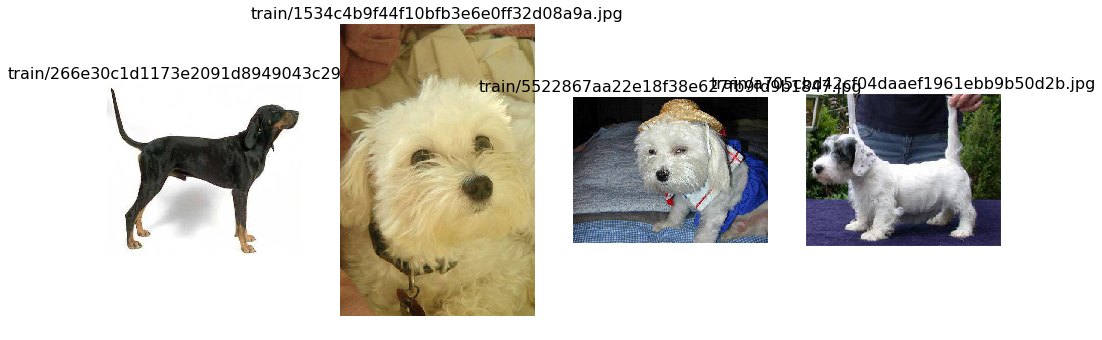

In [26]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified:train/f430cdcc2b98a6e3566e71b27ae60e71.jpg


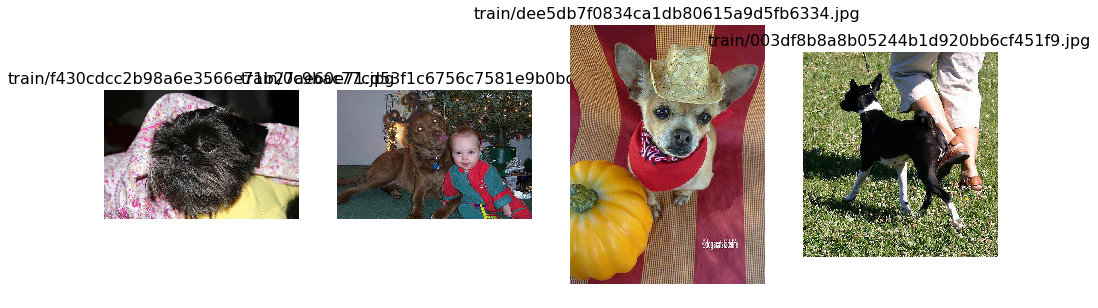

In [27]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [38]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most uncertain predictions


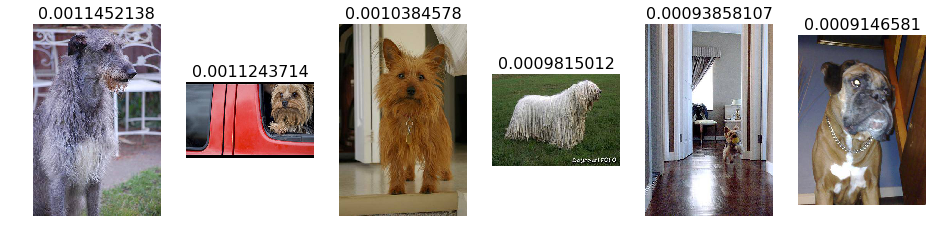

In [40]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:6]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

### Try to predict breed of single dog image

In [ ]:
# need to do this once before using learn.predict_array(), or you seem to get incorrect results 
learn.predict()

test/a5049952a1a2ea0473e6520db5e4a4fb.jpg


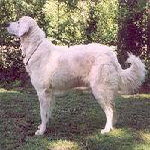

In [75]:
fn = data.test_ds.fnames[17]; print(fn)
#fn = "train/266e30c1d1173e2091d8949043c2941a.jpg"
im = Image.open(PATH+fn).resize((150,150)); im

#url = "http://scontent-sea1-1.xx.fbcdn.net/v/t1.0-1/p200x200/19554076_1201765089946941_8000746464863298198_n.jpg?oh=d1804a2e1c431ac6c8c8a3822ded6e12&oe=5B266D7E"
#im = Image.open(urllib2.urlopen(url)).resize((150,150)); im 

In [76]:
trn_tfms,val_tfms = tfms_from_model(arch, image_size)
tfim = val_tfms(np.array(im))
learn.precompute = False
single_image_preds = learn.predict_array(tfim[None])
i = np.argmax(single_image_preds)
print(learn.data.classes[i])
print(np.exp(single_image_preds[0][i]))

kuvasz
0.9971535
